In [2]:
import pandas as pd
import numpy as np
import lib as l
import re
import string
import math
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import warnings
warnings.simplefilter("ignore")
#from fancyimpute import KNN
from datetime import timedelta
from sklearn.cluster import KMeans
from pyod.models.iforest import IForest
#from pyod.models.abod import ABOD
#from pyod.models.knn import KNN
#from pyod.models.auto_encoder import AutoEncoder
#import keras
#import tensorflow as tf
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
#from sklearn.impute import KNNImputer
import scipy as sp
from sklearn.cluster import DBSCAN
#interactive plots
%matplotlib notebook

In [3]:
# read file
file_name = 'baldwin_pump_data.csv'

df = pd.read_csv(file_name, parse_dates = True, index_col = 0)

In [ ]:
df.head()

In [ ]:
# null values
df_null = l.proportion_null_values(df)
df_null

In [4]:
#drop rows with all null values
df.dropna(how = 'all', axis=0, inplace = True)

In [ ]:
# check for correlation 
df.corr().to_excel('baldwin_correlation.xlsx')

In [ ]:
## Print Summary Statistics
summary_stats = l.summary_stats(df)
summary_stats

In [5]:
################ impute missing values ####################
#### KNN Impute #####
df_KNN_impute = l.KNNImpute(df,7,"uniform")

# normalise KNN imputed df
df_KNN_impute_zscale = l.zscale(df_KNN_impute)

In [ ]:
########### eliminate features using VIF ########
list_of_selected_features = df_KNN_impute_zscale.columns.tolist()

new_list_of_selected_features = l.eliminate_feature_using_VIF(df_KNN_impute_zscale,list_of_selected_features,20)

print(new_list_of_selected_features)
#save correlation matrix of selected features
#df[list_of_selected_features].corr().to_excel('selected_corr.xlsx')

<IPython.core.display.Javascript object>


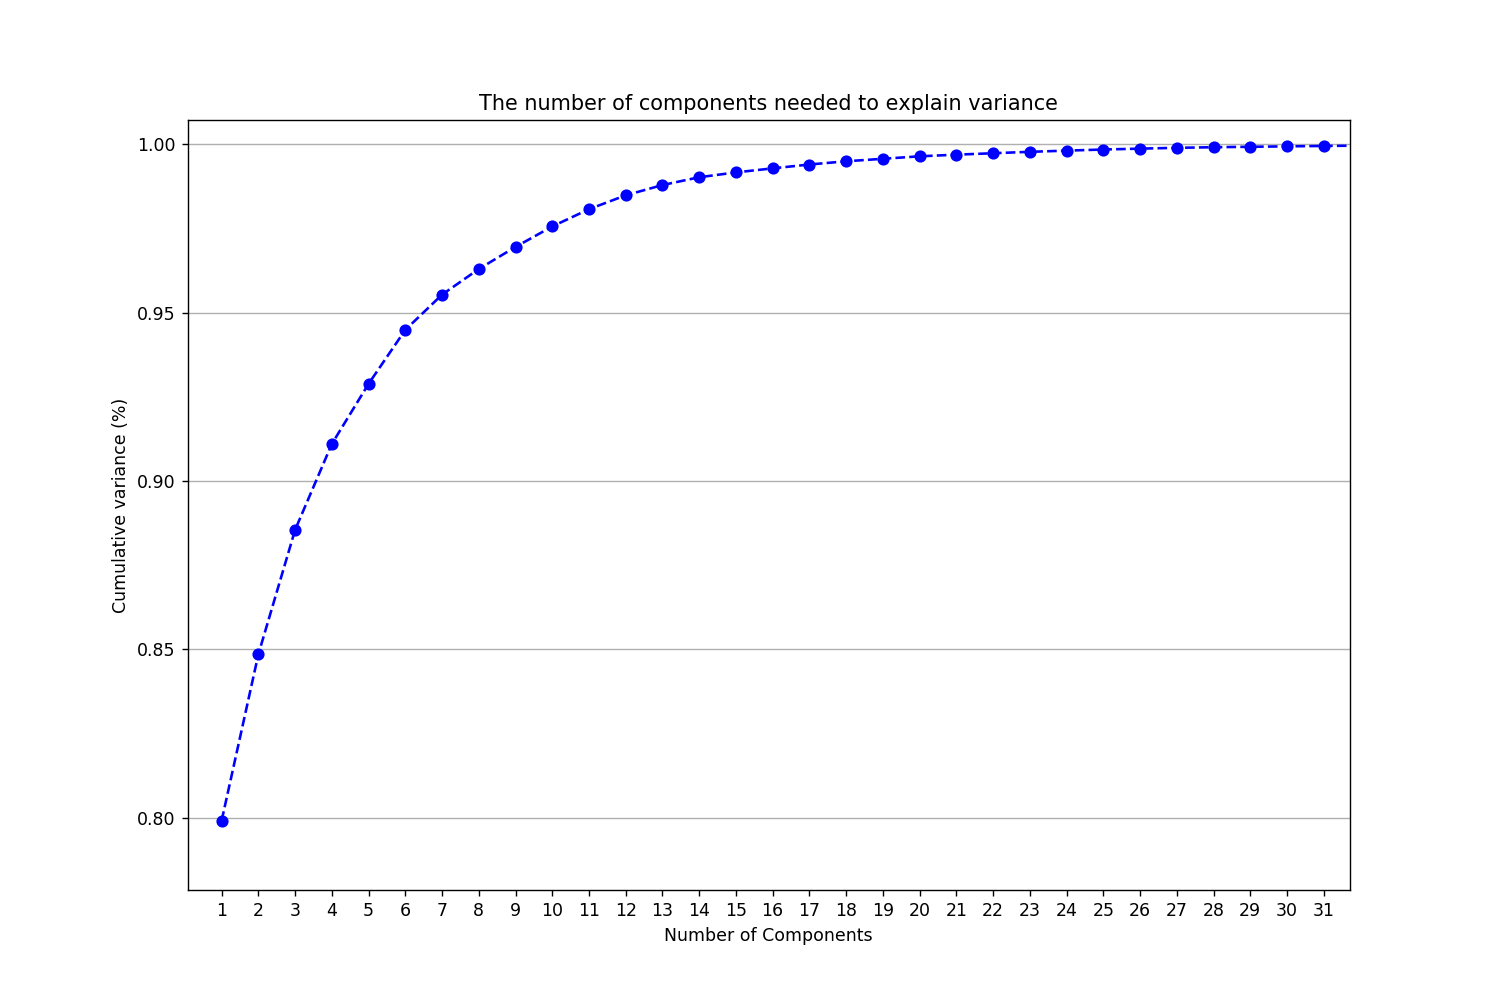

In [6]:
########### PCA + Mahalanobis Distance ################
# get optimum component for PCA
_ = l.optimum_component_for_PCA(df_KNN_impute_zscale)

In [ ]:
## get mahalanobis Distance of vectors in data
df_PCA=l.PCAMahalanobisDistanceOfData(df_KNN_impute_zscale,3)
#df_PCA.to_excel('PCA_Cluster.xlsx')

In [ ]:
df_PCA.to_excel('Results/PCA_Cluster3D.xlsx')

In [ ]:
#2d plot
#plt.scatter(df_PCA[0],df_PCA[1])

#3d plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_PCA[0],df_PCA[1],df_PCA[2])

plt.show()

In [ ]:
## Histogram plot of Mahalanobis distance
plt.figure(figsize=(6,5))
sns.distplot(df_PCA['mahala'].values, #np.square(df_x[df_x['mahala']>=600].mahala.values), 
             #bins = 50, 
             kde= False);
#plt.xticks(np.arange(0, 26000, step=1000))
#plt.yticks(np.arange(0, 120, step=5))
plt.show()

# Boxplot of Mahalanobis distance
plt.figure(figsize=(6,5))
df_PCA.boxplot(column = 'mahala')
plt.show()

# plot mahalanobis>15
plt.figure(figsize=(6,5))
df_PCA['mahala'].plot()
plt.show()

In [ ]:
############# KMeans ########################

clusters = range(1,15)

#Sum of squared distances of samples to their closest cluster center.
TSS = []
for i in clusters:
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(df_KNN_impute_zscale)
    TSS.append(kmeans.inertia_)
    
plt.plot(clusters,TSS, 'bx-')
plt.xticks(np.arange(0, 16, step=1))
plt.show()

In [ ]:
df_KMeans = df_KNN_impute.copy()
kmeans = KMeans(n_clusters=8, random_state=0)
cluster = kmeans.fit_predict(df_KNN_impute_zscale)
df_KMeans['Cluster'] = cluster
df_KMeans.to_excel('Results/KMeans_cluster.xlsx')

In [ ]:
###### Cluster Profiling ############
cluster_avg = df_KMeans.groupby('Cluster').mean()
cluster_std = df_KMeans.groupby('Cluster').std()
population_avg = df_KMeans.mean()
# Calculate relative importance of cluster's attribute value compared to population
relative_imp = ((cluster_avg - population_avg)/ cluster_std).round(2)

# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(20, 12))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()

In [ ]:
## distance of population mean with clusters

pop_md_from_clusters = {}
for i in range(8):
    MD = np.linalg.norm(population_avg-df_KMeans[df_KMeans.Cluster == i].mean())
    cos= 1-cosine_similarity(population_avg.values.reshape(1,-1), df_KMeans[df_KMeans.Cluster == i].mean().values.reshape(1,-1))[0][0]
    pop_md_from_clusters['C'+str(i)]= [MD, cos]
pop_md_from_clusters

In [ ]:
####### DBSCAN #############
df_DBSCAN = df_KNN_impute.copy()
clustering = DBSCAN(eps=3, min_samples=2).fit(df_KNN_impute_zscale)
df_DBSCAN['Cluster'] = clustering.labels_

In [ ]:
df_DBSCAN['Cluster'].hist(bins = 50)

In [ ]:
df_DBSCAN.to_excel('Results/DBSCAN_Cluster1.xlsx')

In [ ]:
#df[df['Date'] < df.Date.iloc[0]+timedelta(days=1)].info()
# x = df[df['BFP_SUCT_HDR_PRESS________'].isnull()].index.time
## get date column
#df['Date'] = df.index.date
#df.info()